In [16]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import sys
lya = 1215.67

In [17]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

In [9]:
# main folder where the processed files are
nside = 16
#basedir = '/Users/jfarr/Projects/test_data/process_output_G_hZsmooth_4096_32_sr2.0_bm1_biasG18_picos_nside{}'.format(nside)
basedir = '../example_data/update_230518/'

In [10]:
pix = 1
pix_100 = int(pix/100)
dirname = basedir+'/'+str(pix_100)+'/'+str(pix)+'/'
suffix = str(nside)+'-'+str(pix)+'.fits'
print('dir name',dirname)

dir name ../example_data/update_230518//0/1/


First section: opens test gaussian files with and without RSDs.
These will not be written to disc in future, but are produced for testing purposes.
It simply plots one skewer from a file with RSDs and the corresponding skewer from a file without RSDs.
The corresponding velocity skewer is plotted for reference too.

In [11]:
# open picca files with and without RSDs, and the 
gaussian_RSD_filename = dirname+'/picca-gaussian-RSD-'+suffix
gaussian_RSD = fits.open(gaussian_RSD_filename)
print('With RSDs:')
gaussian_RSD.info()

gaussian_noRSD_filename = dirname+'/picca-gaussian-noRSD-'+suffix
gaussian_noRSD = fits.open(gaussian_noRSD_filename)
print('\nWithout RSDs:')
gaussian_RSD.info()

With RSDs:
Filename: ../example_data/update_230518//0/1//picca-gaussian-RSD-16-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  CATALOG       1 PrimaryHDU      12   (5, 568)   float32   
  1  IV            1 ImageHDU        13   (5, 568)   float32   
  2  LOGLAM_MAP    1 ImageHDU        12   (568,)   float32   
  3  CATALOG       1 BinTableHDU     28   5R x 7C   [E, E, E, K, E, K, K]   

Without RSDs:
Filename: ../example_data/update_230518//0/1//picca-gaussian-RSD-16-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  CATALOG       1 PrimaryHDU      12   (5, 568)   float32   
  1  IV            1 ImageHDU        13   (5, 568)   float32   
  2  LOGLAM_MAP    1 ImageHDU        12   (568,)   float32   
  3  CATALOG       1 BinTableHDU     28   5R x 7C   [E, E, E, K, E, K, K]   


In [12]:
print('Check that the highest z QSO is the same in both files:')
iskewer = np.argmax(gaussian_RSD[3].data['Z'])
print('row number:',iskewer,'MOCKID:',gaussian_RSD[3].data['THING_ID'][iskewer])
iskewer = np.argmax(gaussian_noRSD[3].data['Z'])
print('row number:',iskewer,'MOCKID:',gaussian_noRSD[3].data['THING_ID'][iskewer])

Check that the highest z QSO is the same in both files:
row number: 4 MOCKID: 267
row number: 4 MOCKID: 267


In [13]:
# open colore file to get a velocity skewer
gaussian_colore_filename = dirname+'/gaussian-colore-'+suffix
gaussian_colore = fits.open(gaussian_colore_filename)
print('colore:')
gaussian_colore.info()
iskewer_colore = np.argmax(gaussian_colore[1].data['MOCKID']==gaussian_RSD[3].data['THING_ID'][iskewer])

print('\nCheck that the we\'re looking at the same QSO in the colore file:')
print('row number:',iskewer_colore,'MOCKID:',gaussian_colore[1].data['MOCKID'][iskewer_colore])

colore:
Filename: ../example_data/update_230518//0/1//gaussian-colore-16-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  CATALOG       1 BinTableHDU     26   7R x 6C   [E, E, E, E, E, K]   
  2  GAUSSIAN_DELTA    1 ImageHDU        13   (2048, 7)   float32   
  3  VELOCITY      1 ImageHDU        13   (2048, 7)   float32   
  4  COSMO         1 BinTableHDU     22   2048R x 4C   [E, E, E, E]   

Check that the we're looking at the same QSO in the colore file:
row number: 6 MOCKID: 267


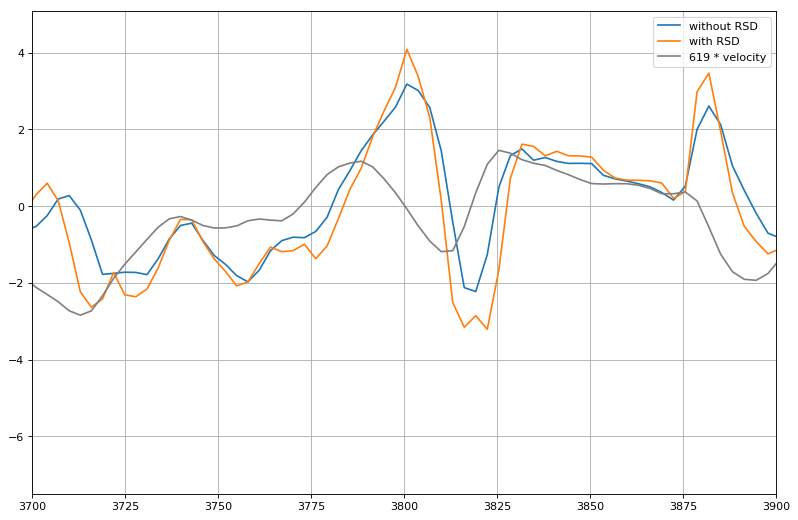

In [46]:
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(10**gaussian_noRSD[2].data,gaussian_noRSD[0].data[:,iskewer],label='without RSD')
plt.plot(10**gaussian_RSD[2].data,gaussian_RSD[0].data[:,iskewer],label='with RSD')

scale_vel = 3/max(gaussian_colore[3].data[iskewer_colore,:])
plt.plot(lya*(1+gaussian_colore[4].data['Z']),scale_vel*gaussian_colore[3].data[iskewer_colore,:],label='{:2.0f} * velocity'.format(scale_vel),c=(0.5,0.5,0.5))

x_lower = 3700.
x_width = 200.
x_upper = x_lower + x_width

plt.xlim(x_lower,x_upper)
plt.legend()
plt.grid()
plt.show()

THIS IS NOT VALID AT THE MOMENT: NEED TO CONVERT TO PHYSICAL SKEWERS FIRST

Second section: this mimics the process of adding linear RSDs as defined in RSD.py
It shows the 'shifting' of the cells by listing the original index and z, the new ones and the weights.
It them plots a gaussian skewer with and without RSDs, and the corresponding (scaled) velocity skewer.

In [47]:
gaussian_colore_filename = dirname+'/gaussian-colore-'+suffix
gaussian_colore = fits.open(gaussian_colore_filename)
gaussian_colore.info()

gaussian_skewer = gaussian_colore[2].data[iskewer_colore,:]
velocity_skewer = gaussian_colore[3].data[iskewer_colore,:]
Z = gaussian_colore[4].data['Z']
N_cells = gaussian_skewer.shape[0]
D = gaussian_colore[4].data['D']
SIGMA_G = gaussian_colore[2].header['SIGMA_G']

Filename: ../example_data/update_230518//0/1//gaussian-colore-16-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  CATALOG       1 BinTableHDU     26   7R x 6C   [E, E, E, E, E, K]   
  2  GAUSSIAN_DELTA    1 ImageHDU        13   (2048, 7)   float32   
  3  VELOCITY      1 ImageHDU        13   (2048, 7)   float32   
  4  COSMO         1 BinTableHDU     22   2048R x 4C   [E, E, E, E]   


In [48]:
import process_functions as pf
physical_skewer = pf.gaussian_to_lognormal_delta(gaussian_colore[2].data,SIGMA_G,D)[iskewer_colore,:] + 1

In [53]:
new_physical_skewer = np.zeros(gaussian_skewer.shape)
for j in range(N_cells):
    z_cell=Z[j]
    dz_cell = velocity_skewer[j]
    new_z_cell=z_cell+dz_cell
    j_upper = np.searchsorted(Z,new_z_cell)
    j_lower = j_upper - 1
    if j_lower < 0:
        w_upper = 1.0
        w_lower = 0.0
        j_lower += 1
    elif j_upper >= N_cells:
        w_lower = 1.0
        w_upper = 0.0
        j_upper -= 1
    else:
        z_upper = Z[j_upper]
        z_lower = Z[j_lower]
        w_upper = abs(new_z_cell - z_lower)/(z_upper - z_lower)
        w_lower = abs(new_z_cell - z_upper)/(z_upper - z_lower)
    print('z={:2.4f}, j={:2.0f} -> dz={:2.4f} -> new_z={:2.4f}, z in [{:2.4f},{:2.4f}], j in [{:2.0f},{:2.0f}] -> w_lower: {:2.4f}, w_upper: {:2.4f}'.format(z_cell,j,dz_cell,new_z_cell,z_lower,z_upper,j_lower,j_upper,w_lower,w_upper))
    new_physical_skewer[j_upper] += w_upper*physical_skewer[j]
    new_physical_skewer[j_lower] += w_lower*physical_skewer[j]

z=0.0004, j= 0 -> dz=0.0015 -> new_z=0.0019, z in [0.0012,0.0020], j in [ 1, 2] -> w_lower: 0.0509, w_upper: 0.9491
z=0.0012, j= 1 -> dz=0.0019 -> new_z=0.0031, z in [0.0028,0.0036], j in [ 3, 4] -> w_lower: 0.5706, w_upper: 0.4294
z=0.0020, j= 2 -> dz=0.0022 -> new_z=0.0042, z in [0.0036,0.0043], j in [ 4, 5] -> w_lower: 0.2099, w_upper: 0.7901
z=0.0028, j= 3 -> dz=0.0022 -> new_z=0.0050, z in [0.0043,0.0051], j in [ 5, 6] -> w_lower: 0.1965, w_upper: 0.8035
z=0.0036, j= 4 -> dz=0.0020 -> new_z=0.0056, z in [0.0051,0.0059], j in [ 6, 7] -> w_lower: 0.4058, w_upper: 0.5942
z=0.0043, j= 5 -> dz=0.0019 -> new_z=0.0062, z in [0.0059,0.0067], j in [ 7, 8] -> w_lower: 0.6142, w_upper: 0.3858
z=0.0051, j= 6 -> dz=0.0017 -> new_z=0.0069, z in [0.0067,0.0075], j in [ 8, 9] -> w_lower: 0.7979, w_upper: 0.2021
z=0.0059, j= 7 -> dz=0.0015 -> new_z=0.0075, z in [0.0067,0.0075], j in [ 8, 9] -> w_lower: 0.0659, w_upper: 0.9341
z=0.0067, j= 8 -> dz=0.0013 -> new_z=0.0080, z in [0.0075,0.0083], j in 

z=0.7483, j=777 -> dz=-0.0032 -> new_z=0.7451, z in [0.7446,0.7458], j in [774,775] -> w_lower: 0.6364, w_upper: 0.3636
z=0.7495, j=778 -> dz=-0.0036 -> new_z=0.7459, z in [0.7458,0.7471], j in [775,776] -> w_lower: 0.9296, w_upper: 0.0704
z=0.7507, j=779 -> dz=-0.0039 -> new_z=0.7468, z in [0.7458,0.7471], j in [775,776] -> w_lower: 0.2070, w_upper: 0.7930
z=0.7519, j=780 -> dz=-0.0042 -> new_z=0.7477, z in [0.7471,0.7483], j in [776,777] -> w_lower: 0.4982, w_upper: 0.5018
z=0.7531, j=781 -> dz=-0.0045 -> new_z=0.7486, z in [0.7483,0.7495], j in [777,778] -> w_lower: 0.7301, w_upper: 0.2699
z=0.7543, j=782 -> dz=-0.0046 -> new_z=0.7497, z in [0.7495,0.7507], j in [778,779] -> w_lower: 0.7997, w_upper: 0.2003
z=0.7556, j=783 -> dz=-0.0045 -> new_z=0.7511, z in [0.7507,0.7519], j in [779,780] -> w_lower: 0.6721, w_upper: 0.3279
z=0.7568, j=784 -> dz=-0.0039 -> new_z=0.7529, z in [0.7519,0.7531], j in [780,781] -> w_lower: 0.2176, w_upper: 0.7824
z=0.7580, j=785 -> dz=-0.0031 -> new_z=0

In [62]:
new_physical_skewer += 1E-10

In [63]:
new_gaussian_skewer = pf.lognormal_delta_to_gaussian(np.reshape(new_physical_skewer,(1,new_physical_skewer.shape[0]))-1,SIGMA_G,D)
new_gaussian_skewer = np.reshape(new_gaussian_skewer,new_gaussian_skewer.shape[1])

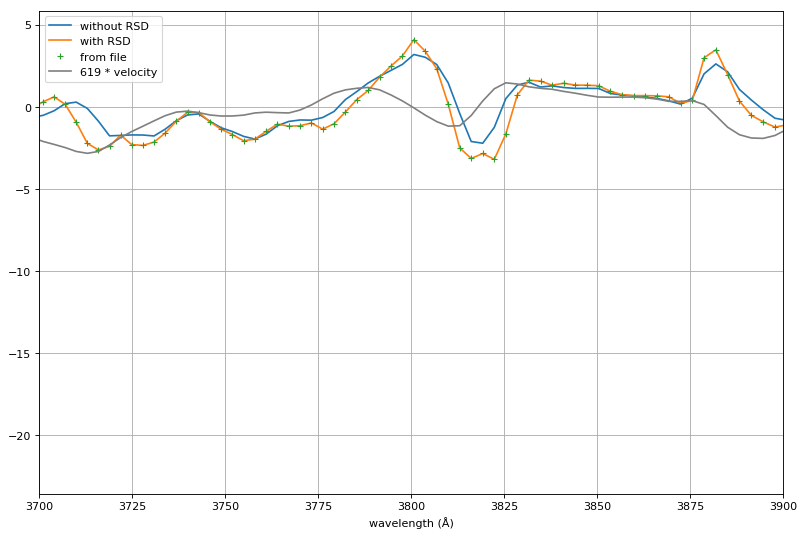

In [66]:
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
scale_vel = 3/max(velocity_skewer)
plt.plot(lya*(1+Z),gaussian_skewer,label='without RSD')
plt.plot(lya*(1+Z),new_gaussian_skewer,label='with RSD')
plt.plot(10**gaussian_RSD[2].data,gaussian_RSD[0].data[:,iskewer],'+',label='from file')
plt.plot(lya*(1+Z),scale_vel*velocity_skewer,label='{:2.0f} * velocity'.format(scale_vel),c=(0.5,0.5,0.5))

plt.xlim(x_lower,x_upper)
plt.xlabel('wavelength (Å)')
plt.legend()
plt.grid()
plt.show()

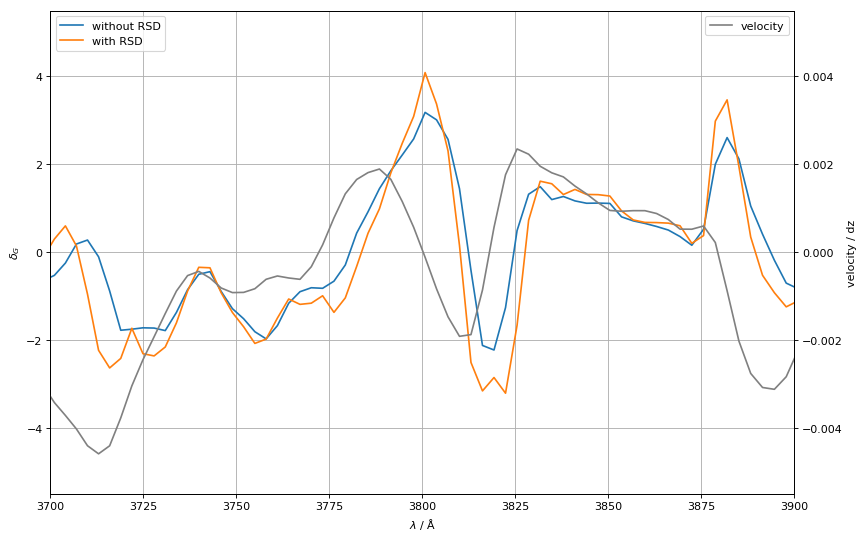

In [52]:
fig, ax1 = plt.subplots(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
lambdas = lya*(1+Z)

#for future: colour using the velocity gradient
velocity_skewer_gradient = np.zeros(velocity_skewer.shape)
velocity_skewer_gradient[0] = (velocity_skewer[0]-velocity_skewer[1])/(lambdas[0]-lambdas[1])
velocity_skewer_gradient[-1] = (velocity_skewer[-2]-velocity_skewer[-1])/(lambdas[-2]-lambdas[-1])
for i in range(1,velocity_skewer.shape[0]-1):
    velocity_skewer_gradient[i] += (velocity_skewer[i-1]-velocity_skewer[i+1])/(lambdas[i-1]-lambdas[i+1])
    
from matplotlib.colors import ListedColormap, BoundaryNorm
cmap=plt.get_cmap('RdBu')
max_vel_grad = max(abs(velocity_skewer_gradient))
norm = BoundaryNorm([-max_vel_grad,max_vel_grad], cmap.N)

ax1.plot(lambdas,gaussian_skewer,label='without RSD')
ax1.set_xlabel('$\lambda$ / Å')
ax1.set_ylabel('$\delta_G$')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.plot(lambdas,velocity_skewer,label='velocity',c=(0.5,0.5,0.5))
ax2.set_ylabel('velocity / dz')

#align the axes at 0
align_yaxis(ax1, 0, ax2, 0)

#set the first axis ticks
ax1.set_ylim(-5.5,5.5)
ylim1 = ax1.get_ylim()
len1 = ylim1[1]-ylim1[0]
yticks1 = ax1.get_yticks()
rel_dist = [(y-ylim1[0])/len1 for y in yticks1]

#set the second axis ticks
ax2.set_ylim(-0.0055,0.0055)
ylim2 = ax2.get_ylim()
len2 = ylim2[1]-ylim2[0]
yticks2 = [ry*len2+ylim2[0] for ry in rel_dist]
ax2.set_yticks(yticks2)
ax2.set_ylim(ylim2)

#set legends and grids
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.yaxis.grid()
ax1.xaxis.grid()

plt.xlim(x_lower,x_upper)
plt.savefig('RSD_example_without_RSD.pdf')

ax1.plot(lambdas,new_gaussian_skewer,label='with RSD')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.savefig('RSD_example_with_RSD.pdf')

plt.show()